In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch_deeptype import DeeptypeModel, DeeptypeTrainer
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

# 2) Load and prepare the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# train/test split (we'll train only on the train split here)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to torch tensors and DataLoader
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
train_dataset   = TensorDataset(X_train_tensor, y_train_tensor)
train_loader    = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [3]:
# 3) Define a simple DeeptypeModel subclass for Iris
class IrisNet(DeeptypeModel):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_layer   = nn.Linear(input_dim, hidden_dim)
        self.h1            = nn.Linear(hidden_dim, hidden_dim)
        self.cluster_layer = nn.Linear(hidden_dim, hidden_dim // 2)
        self.output_layer  = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        hidden = self.get_hidden_representations(x)
        return self.output_layer(hidden)

    def get_input_layer_weights(self) -> torch.Tensor:
        return self.input_layer.weight

    def get_hidden_representations(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.h1(x))
        x = torch.relu(self.cluster_layer(x))
        return x

# 4) Instantiate the DeeptypeTrainer
model = IrisNet(input_dim=4, hidden_dim=16, output_dim=3)
trainer = DeeptypeTrainer(
    model           = model,
    train_loader    = train_loader,
    primary_loss_fn = nn.CrossEntropyLoss(),
    num_clusters    = 3,        # true number of Iris classes
    sparsity_weight = 0.01,
    cluster_weight  = 0.5,
    verbose         = True,
)

In [4]:
# 5) Run the two‐stage training
trainer.train(
    main_epochs           = 10,
    main_lr               = 1e-3,
    pretrain_epochs       = 5,
    pretrain_lr           = 1e-2,
    train_steps_per_batch = 5
)

Starting Phase 1: 5 epochs @ lr=0.01
[Epoch 1/5]  Primary: 1.0992  Sparsity: 4.2722
[Epoch 2/5]  Primary: 0.9004  Sparsity: 3.8140
[Epoch 3/5]  Primary: 0.6535  Sparsity: 3.6381
[Epoch 4/5]  Primary: 0.4115  Sparsity: 3.6548
[Epoch 5/5]  Primary: 0.3626  Sparsity: 3.7315
→ Phase 1 training complete.

Starting Phase 2: 10 epochs @ lr=0.001 with 5 steps/batch
[Phase 2 | Epoch 1/10]  Primary: 0.2052  Sparsity: 3.7043  Cluster: 0.8384
[Phase 2 | Epoch 2/10]  Primary: 0.1951  Sparsity: 3.6654  Cluster: 0.7802
[Phase 2 | Epoch 3/10]  Primary: 0.1823  Sparsity: 3.6292  Cluster: 0.7081
[Phase 2 | Epoch 4/10]  Primary: 0.1840  Sparsity: 3.5985  Cluster: 0.7938
[Phase 2 | Epoch 5/10]  Primary: 0.1670  Sparsity: 3.5671  Cluster: 0.6919
[Phase 2 | Epoch 6/10]  Primary: 0.1623  Sparsity: 3.5491  Cluster: 0.6750
[Phase 2 | Epoch 7/10]  Primary: 0.1482  Sparsity: 3.5372  Cluster: 0.6760
[Phase 2 | Epoch 8/10]  Primary: 0.1515  Sparsity: 3.5136  Cluster: 0.6006
[Phase 2 | Epoch 9/10]  Primary: 0.1379 

In [12]:
# 6) Extract clusters & input importances
# build a dataset over the full iris data for clustering
X_full_tensor = torch.from_numpy(X).float()
y_full_tensor = torch.from_numpy(y).long()
full_dataset  = TensorDataset(X_full_tensor, y_full_tensor)

centroids, labels = trainer.get_clusters(full_dataset)
importances       = model.get_input_importance()
sorted_idx        = model.get_sorted_input_indices()

print("Centroids shape:", centroids.shape)
print("Cluster Assignments:", labels)
print("Input importances:", importances)

Centroids shape: torch.Size([3, 8])
Cluster Assignments: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0
 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
Input importances: tensor([0.9402, 0.6984, 1.0959, 0.7529], grad_fn=<LinalgVectorNormBackward0>)


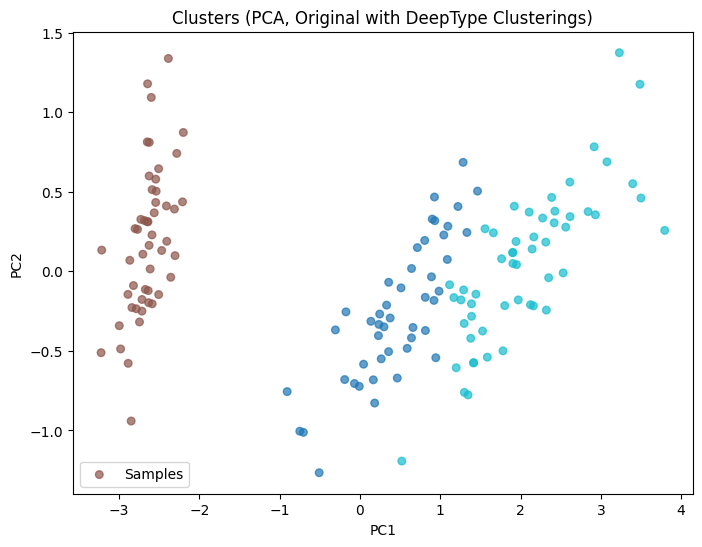

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

centroids, labels = trainer.get_clusters(full_dataset)

# PCA projection
pca = PCA(n_components=2)
hidden_2d = pca.fit_transform(X)
# Plot
plt.figure(figsize=(8,6))
plt.scatter(hidden_2d[:,0], hidden_2d[:,1], c=labels, cmap='tab10', s=30, alpha=0.7, label='Samples')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters (PCA, Original with DeepType Clusterings)')
plt.legend()
plt.show()

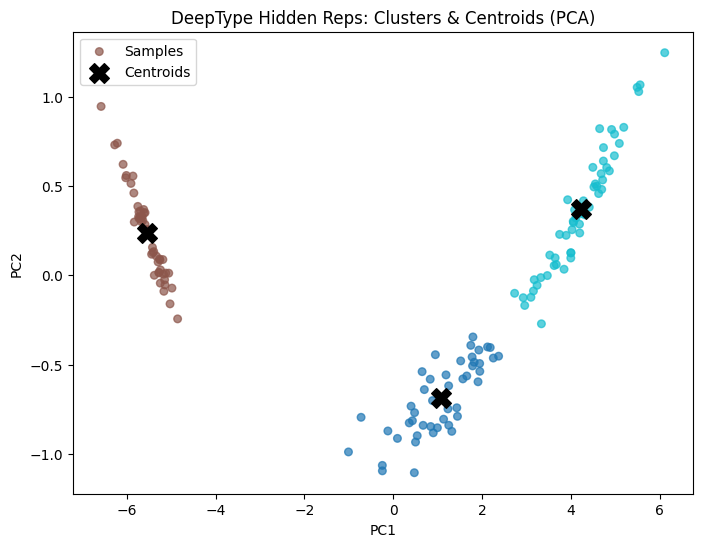

In [16]:
model.eval()
with torch.no_grad():
    hidden_reps = model.get_hidden_representations(X_full_tensor).cpu().numpy()

# PCA projection
pca = PCA(n_components=2)
hidden_2d = pca.fit_transform(hidden_reps)
centroids_2d = pca.transform(centroids.cpu().numpy())

# Plot
plt.figure(figsize=(8,6))
plt.scatter(hidden_2d[:,0], hidden_2d[:,1], c=labels, cmap='tab10', s=30, alpha=0.7, label='Samples')
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], c='black', marker='X', s=200, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('DeepType Hidden Reps: Clusters & Centroids (PCA)')
plt.legend()
plt.show()